# UIUC Electricity and Steam Demands

This notebook calculates the average seasonal and hourly steam and electricity demands.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size'] = '16'
plt.style.use('ggplot')

colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}

In [27]:
for i in [15,16,17,18,19]:
    if i is 15:
        df = pd.read_csv(f'../steamfy{i}.csv', index_col='Date and Time', parse_dates=True)
    else:
        df_new = pd.read_csv(f'../steamfy{i}.csv', index_col='Date and Time', parse_dates=True)
        df = pd.concat([df, df_new], axis=0)

In [28]:
df.rename(columns={'Date and Time':'time'}, inplace=True)

We use the equation

$$P_{th} = \dot{Q} = \dot{m}c_p\Delta T$$

This equation gives the thermal power required to heat a certain amount of water to a certain temperature. 

At 120$^\circ$C the $c_p$ of water is 4243.5 [J/kg K]

$\Delta T$ is 179$^\circ$C

Alternatively, we can use the change in enthalpy to calculate the power requirement. According to the master plan the inlet enthalpy is 196 BTU/lb and the outlet enthalpy after superheating is 1368 BTU/lb. 

We can convert to $P_{th}$ by 

$$P_{th} = \dot{m}\Delta h$$

Using the typical history of steam mass flow rates

In [29]:
h_in = 196 # BTU/lb
h_out = 1368 # BTU/lb
btu_to_kwh = 0.29307107


# times 0.29307107 to convert from BTU/hr to kilowatts
to_kwth = lambda mdot: (mdot*(h_out-h_in))*btu_to_kwh

In [30]:
df['kw'] = df['Value (KLBS/HR)'].apply(to_kwth)
# df['kw'].to_csv('uiuc_steam_data.csv')

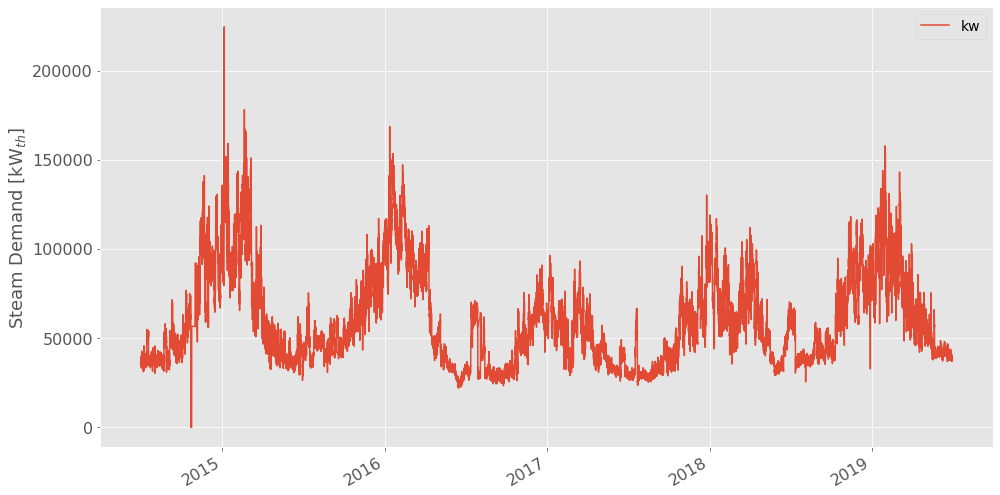

In [31]:
df.kw.plot(figsize=(16,9))
plt.ylabel(r'Steam Demand [kW$_{th}$]', fontsize=18)
plt.xlabel(r'', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [32]:
spring_mask = (df.index.month >= 3) & (df.index.month <= 5) 
summer_mask = (df.index.month >= 6) & (df.index.month <= 8)
fall_mask = (df.index.month >= 9) & (df.index.month <= 11) 
winter_mask = (df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2) 
seasons = {'spring':spring_mask,
           'summer':summer_mask,
           'fall':fall_mask,
           'winter':winter_mask}

In [33]:
seasonal_hourly_profile = {}
for season in seasons:
    mask = seasons[season]
    season_df = df[mask]
    hours_grouped = season_df.groupby(season_df.index.hour)
    
    avg_hourly = np.zeros(len(hours_grouped))
    std_hourly = np.zeros(len(hours_grouped))
    for i, hour in enumerate(hours_grouped.groups):
        hour_data = hours_grouped.get_group(hour)
        avg_hourly[i] = hour_data.kw.mean()
        std_hourly[i] = hour_data.kw.std()
        
    seasonal_hourly_profile[season] = avg_hourly
    colname = season+"_dist"
    seasonal_hourly_profile[colname] = avg_hourly/(4*avg_hourly.sum())

In [34]:
distribution_df = pd.DataFrame(seasonal_hourly_profile)
distribution_df

,spring,spring_dist,summer,summer_dist,fall,fall_dist,winter,winter_dist
0,58712.504500,0.010427,38270.226063,0.010163,53157.647719,0.010307,84891.734542,0.010361
1,57950.115272,0.010291,37776.503142,0.010032,52027.017866,0.010088,83655.292552,0.010210
2,57720.787982,0.010251,37559.243896,0.009974,51611.811201,0.010007,83285.669900,0.010165
3,58031.723557,0.010306,37605.139533,0.009986,51523.577126,0.009990,83383.034274,0.010177
4,58552.477527,0.010398,37696.002062,0.010010,51748.528318,0.010034,83772.087053,0.010224
5,59282.143307,0.010528,37944.205907,0.010076,52346.413190,0.010150,84417.722968,0.010303
6,60621.115173,0.010766,38331.117190,0.010179,53477.339263,0.010369,86263.711838,0.010528
7,63454.627414,0.011269,39406.152220,0.010464,56901.909455,0.011033,90672.370491,0.011066
8,63786.910115,0.011328,40159.298462,0.010664,58381.422381,0.011320,92538.734170,0.011294
9,62602.626814,0.011118,40578.997852,0.010776,57253.324885,0.011101,90596.838755,0.011057


spring
summer
fall
winter


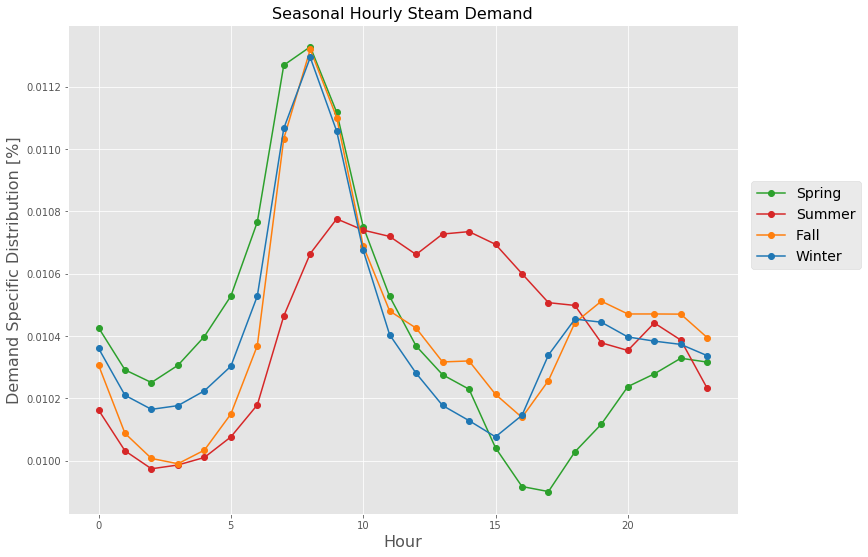

In [35]:
fig, ax = plt.subplots(figsize=(12,9))
colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}
# ax2 = ax.twinx()
for season in seasons:
# for season in ['summer', 'spring']:
    print(season)
    cf_key = season+"_dist"
#     ax.plot(range(24), distribution_df[season], label=season.capitalize(), color=colors[season])
    ax.plot(range(24), distribution_df[cf_key], color=colors[season], marker='o',label=season.capitalize())
ax.set_xlabel('Hour',fontsize=16)
ax.legend(loc=(1.02,0.5),fontsize=14)
# ax.set_ylabel('Power [tons]',fontsize=16)
ax.set_ylabel('Demand Specific Distribution [%]',fontsize=16)
ax.set_title('Seasonal Hourly Steam Demand',fontsize=16)
ax.grid(which='minor')
# fig.savefig("../report/img/cap/seasonal_hourly_cws.png")
plt.show()

In [36]:
distribution_df[['fall_dist', 'winter_dist', 'summer_dist', 'spring_dist']].sum()

fall_dist      0.25
winter_dist    0.25
summer_dist    0.25
spring_dist    0.25
dtype: float64

In [37]:
total = 0.0
for season in seasons:
    data = distribution_df[season+"_dist"]
    for i,value in enumerate(data):
        total += value
        print(f"INSERT INTO \"DemandSpecificDistribution\" VALUES ('UIUC','{season}','H{i+1}','HEAT',{value},'');")

INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H1','HEAT',0.010426878939360876,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H2','HEAT',0.010291484609781194,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H3','HEAT',0.010250757886957604,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H4','HEAT',0.010305977599112405,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H5','HEAT',0.010398459407798452,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H6','HEAT',0.010528042310376271,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H7','HEAT',0.010765833180745229,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H8','HEAT',0.011269042665166706,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H9','HEAT',0.01132805345899232,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H10','HE

In [38]:
N_years = 5
total_steam_demand = df.kw.sum()/N_years/1e6
total_steam_demand  # GWh thermal

518.2135224766623

In [41]:
stm_years = df.groupby(df.index.year)
years = np.arange(2015,2019,1)

steam_demand = np.array([stm_years.get_group(y).kw.sum() for y in years]).mean()
steam_demand/1e6

505.511196745355

## Electricity Demand

In [15]:
df = pd.read_csv('../uiuc_demand_data.csv', index_col='time', parse_dates=True, usecols=['time', 'kw'])
df

,kw
time,
2015-01-01 00:00:00,41903.0
2015-01-01 01:00:00,43479.0
2015-01-01 02:00:00,43572.0
2015-01-01 03:00:00,43253.0
2015-01-01 04:00:00,43566.0
...,...
2019-06-30 18:00:00,55136.0
2019-06-30 19:00:00,54423.0
2019-06-30 20:00:00,57478.0


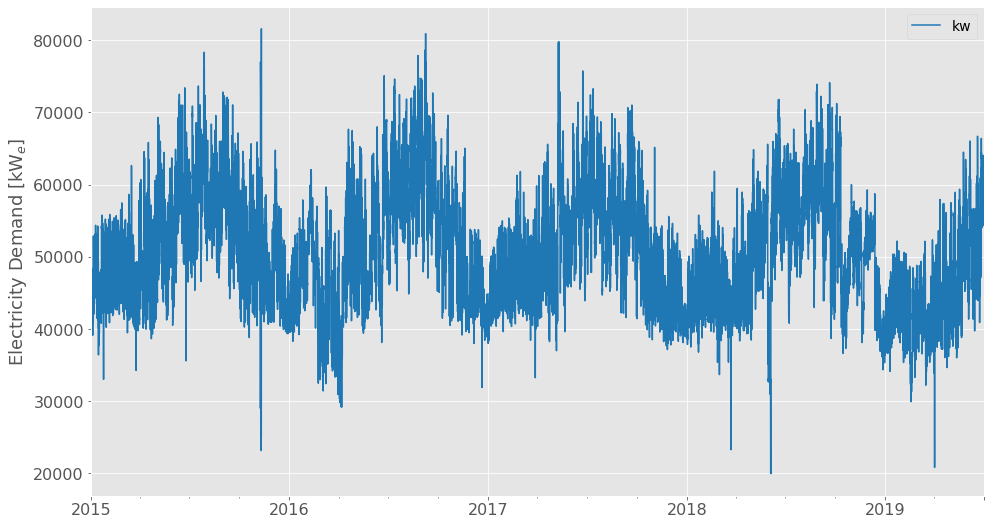

In [16]:
df.kw.plot(figsize=(16,9), color='tab:blue')
plt.ylabel(r'Electricity Demand [kW$_{e}$]', fontsize=18)
plt.xlabel(r'', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [24]:
elc_years = df.groupby(df.index.year)
years = np.arange(2016,2019,1)

elc_demand = np.array([elc_years.get_group(y).kw.sum() for y in years]).mean()
elc_demand/1e6  # GWh(e)

445.86880015065736

In [17]:
spring_mask = (df.index.month >= 3) & (df.index.month <= 5) 
summer_mask = (df.index.month >= 6) & (df.index.month <= 8)
fall_mask = (df.index.month >= 9) & (df.index.month <= 11) 
winter_mask = (df.index.month == 12) | (df.index.month == 1) | (df.index.month == 2) 
seasons = {'spring':spring_mask,
           'summer':summer_mask,
           'fall':fall_mask,
           'winter':winter_mask}

seasonal_hourly_profile = {}
for season in seasons:
    mask = seasons[season]
    season_df = df[mask]
    hours_grouped = season_df.groupby(season_df.index.hour)
    
    avg_hourly = np.zeros(len(hours_grouped))
    std_hourly = np.zeros(len(hour`s_grouped))
    for i, hour in enumerate(hours_grouped.groups):
        hour_data = hours_grouped.get_group(hour)
        avg_hourly[i] = hour_data.kw.mean()
        std_hourly[i] = hour_data.kw.std()
        
    seasonal_hourly_profile[season] = avg_hourly
    colname = season+"_dist"
    seasonal_hourly_profile[colname] = avg_hourly/(4*avg_hourly.sum())
    
distribution_df = pd.DataFrame(seasonal_hourly_profile)
distribution_df

,spring,spring_dist,summer,summer_dist,fall,fall_dist,winter,winter_dist
0,45088.380433,0.009842,55135.974867,0.010052,49857.791220,0.009943,43687.509521,0.009959
1,44369.697826,0.009686,54429.246234,0.009923,49025.711535,0.009777,43207.866918,0.009849
2,43901.410863,0.009583,53876.992452,0.009823,48503.140109,0.009673,42867.905789,0.009772
3,43566.121741,0.009510,53593.384422,0.009771,48099.197799,0.009592,42558.843487,0.009701
4,43321.545645,0.009457,53459.507533,0.009746,47866.843409,0.009546,42395.065039,0.009664
5,43626.234516,0.009523,53806.400445,0.009810,48249.076926,0.009622,42439.367472,0.009674
6,44794.151033,0.009778,55877.588380,0.010187,49418.390120,0.009855,42925.233740,0.009785
7,46194.260466,0.010084,57126.117570,0.010415,50388.815942,0.010049,44088.560168,0.010050
8,47686.142976,0.010410,58590.909685,0.010682,51817.524725,0.010333,45415.297084,0.010352
9,48529.754979,0.010594,58972.045139,0.010751,53093.368132,0.010588,46654.872679,0.010635


spring
summer
fall
winter


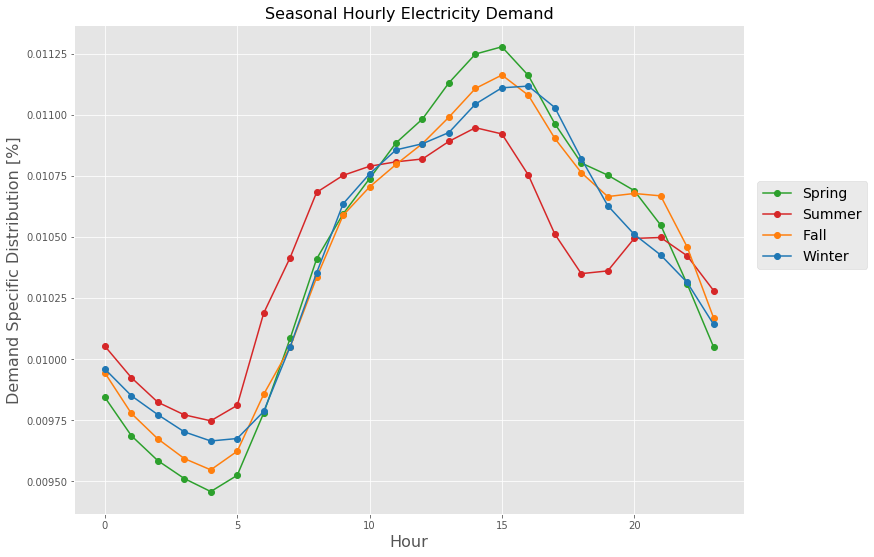

In [18]:
fig, ax = plt.subplots(figsize=(12,9))
colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}
# ax2 = ax.twinx()
for season in seasons:
# for season in ['summer', 'spring']:
    print(season)
    cf_key = season+"_dist"
#     ax.plot(range(24), distribution_df[season], label=season.capitalize(), color=colors[season])
    ax.plot(range(24), distribution_df[cf_key], color=colors[season], marker='o',label=season.capitalize())
ax.set_xlabel('Hour',fontsize=16)
ax.legend(loc=(1.02,0.5),fontsize=14)
# ax.set_ylabel('Power [tons]',fontsize=16)
ax.set_ylabel('Demand Specific Distribution [%]',fontsize=16)
ax.set_title('Seasonal Hourly Electricity Demand',fontsize=16)
ax.grid(which='minor')
# fig.savefig("../report/img/cap/seasonal_hourly_cws.png")
plt.show()

In [22]:
total = 0.0
for season in seasons:
    data = distribution_df[season+"_dist"]
    for i,value in enumerate(data):
        total += value
        print(f"INSERT INTO \"DemandSpecificDistribution\" VALUES ('UIUC','{season}','H{i+1}','LIGHT',{value},'');")

INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H1','LIGHT',0.009842447759895796,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H2','LIGHT',0.009685564856967527,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H3','LIGHT',0.009583341403202045,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H4','LIGHT',0.009510150358510721,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H5','LIGHT',0.009456761271925504,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H6','LIGHT',0.009523272516413942,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H7','LIGHT',0.009778219737805714,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H8','LIGHT',0.010083852892545757,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring','H9','LIGHT',0.010409519406178111,'');
INSERT INTO "DemandSpecificDistribution" VALUES ('UIUC','spring'